**About the Project and Data**
<br>
<br>
This project will use a dataset of health and demographic data to try and predict if an individual has diabetes by using a neural network classifier. The dataset was found on Kaggle at https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset. This dataset consists of records collected from multiple healthcare systems that were scrubbed of identifying data and brought together.
<br>
<br>
The data for this dataset has 100,000 rows of data, each corresponding to an individual. There are also 9 fields of data, encompassing gender, age, hypertension, heart disease, smoking status, BMI, Hb1Ac, blood glucose, and a diabetes diagnosis. Within the target class, there are 8,500 positive diabetes diagnosis and the rest are negative. This is a large imbalance in the target class that shouldbe taken into account.
<br>
<br>
**Data Preparation**
<br>
<br>
Data preparation will include dummying the data, standardization of the data, and then its splitting into training and testing sets of features and target. The neural network will be built using PyTorch.

In [2]:
import pandas as pd

# Loading the data
raw_data = pd.read_csv('diabetes_prediction_dataset.csv')

With the data loaded, we need to prepare it for model training. The dataset will need to be dummied and then standardized. Since a neural network is being used to model the data, I would prefer the data range from 0 to 1. I will use a MinMax scaler instead of z-scores for this reason. After that, the data will need to be split into training and testing sets.

In [4]:
# Preparing the data
dummied = pd.get_dummies(raw_data, dtype='int')

In [5]:
# Subsetting the dummied data into features and targets
dum_feats = dummied.drop(columns=['diabetes'])
targ = dummied['diabetes']

In [6]:
# Selective standard scaling block

# List of columns to scale
to_scale = [
    'age',
    'bmi',
    'HbA1c_level',
    'blood_glucose_level']

#Defining function to selectively scale numeric inputs
def selective_scaler(df_in, cols):
    df_out = pd.DataFrame()
    columns = df_in.columns
    for col in columns:
        if col not in cols:
            df_out[col] = df_in[col]
        else:
            col_mean = df_in[col].mean()
            col_std = df_in[col].std()
            df_out[col] = (df_in[col] - col_mean) / col_std
    return df_out

In [7]:
# Applying the Selective Scaler
sc_feats = selective_scaler(dum_feats, to_scale)

In [8]:
from sklearn.model_selection import train_test_split

# Splitting the features and target into training and testing sets
train_feats, test_feats, train_targ, test_targ = train_test_split(
    sc_feats, targ, test_size=0.15, random_state=21254246)

With the dataset transformed into training and testing feature and target sets, they now need to be converted into tensors for the model to begin training.

In [10]:
import torch
import numpy as np

# Setting torch and numpy seeds
torch.manual_seed(21254246)
np.random.seed(21254246)

# Converting the training and testing sets to tensors
train_feats_tensor = torch.from_numpy(train_feats.to_numpy()).float()
test_feats_tensor = torch.from_numpy(test_feats.to_numpy()).float()
train_targ_tensor = torch.from_numpy(train_targ.to_numpy()).float().view(-1,1)
test_targ_tensor = torch.from_numpy(test_targ.to_numpy()).float().view(-1,1)

**Creating the Model**
<br>
<br>
To create the model, we will piggyback off of the Module class to create our classifier. We will also want to find the optimal amount of training that needs to take place and then create a model using the appropriate number of epochs.

In [12]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop

# Creating the model class
class BrimNet(nn.Module):
    def __init__(self):
        super(BrimNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(15,24),
            torch.nn.ReLU(),
            torch.nn.Linear(24,24),
            torch.nn.ReLU(),
            torch.nn.Linear(24,24),
            torch.nn.ReLU(),
            torch.nn.Linear(24,1),
            torch.nn.Sigmoid()
        )

    def forward(self,x):
        x = self.sequential(x)
        return x



Since this model is designed for classification, a sigmoid activation function is used at the end to ensure that the output can be treated like a probability with those greater than or equal to 0.5 being more likely to have diabetes and less than 0.5 being less likely. The model was also tested using hyperbolic tangent as the activation function and the results were similar to using ReLU, but only 1-2% worse or so.
<br>
<br>
With the network written, we can begin initializing the network and its parameters.

In [14]:
# Initializing network
brimnet = BrimNet()

# Defining loss function and optimizer
criterion = nn.BCELoss()
optimizer = RMSprop(brimnet.parameters())

# Defining the data loader
train_data = TensorDataset(train_feats_tensor, train_targ_tensor)
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)

With the network and parameters initialized, we can figure out how many epochs should be used to train BrimNet.

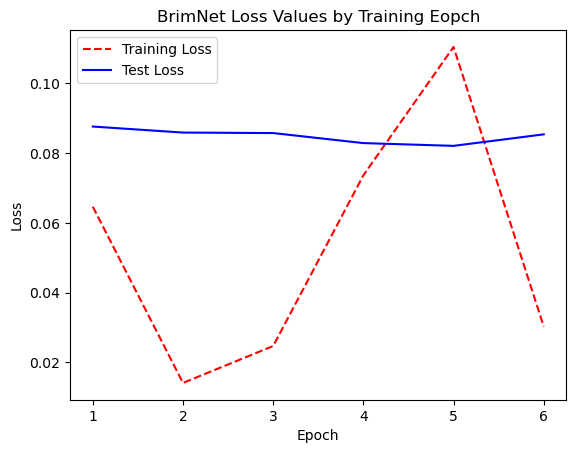

In [16]:
import matplotlib.pyplot as plt

# Training BrimNet to find appropriate number of epochs
epochs = 6  # Max number of epochs
train_losses = []  # List to hold loss value for each epoch
test_losses = []  # List to hold loss value for

for epoch in range(epochs):  # Creating loop to train BrimNet and store loss values after each epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = brimnet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_output = brimnet(train_feats_tensor)
        train_loss = criterion(output, target)
        train_losses.append(train_loss.item())

        test_output = brimnet(test_feats_tensor)
        test_loss = criterion(test_output, test_targ_tensor)
        test_losses.append(test_loss.item())


# Visualizing Loss History
epoch_range = range(1, epochs+1)
plt.plot(epoch_range, train_losses, 'r--')
plt.plot(epoch_range, test_losses, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BrimNet Loss Values by Training Eopch')
plt.show()

The model improves in quality after the first epoch but the loss values slightly increase after the second epoch, likely due to overfitting. The training loss values, for the most part, stay better than the test loss values. This could be due to the imbalance between positive and negative diagnoses of diabetes in the dataset.
<br>
<br>
BrimNet should be run using two epochs. To train the model, we will want to run a fresh instance of the model by zeroing out the gradient.

In [18]:
optimizer.zero_grad()

In [19]:
# Training BrimNet for two epochs
model_epochs = 2
for epoch in range(model_epochs):  # Creating loop to train BrimNet
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = brimnet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [20]:
# Evaluating BrimNet with 2 epochs of training
with torch.no_grad():
    output = brimnet(test_feats_tensor)
    loss = criterion(output, test_targ_tensor)
    test_acc = (output.round() == test_targ_tensor).float().mean()
    print('Loss Value:', loss.item(), '\tTest Accuracy:', test_acc.item())

Loss Value: 0.08294467628002167 	Test Accuracy: 0.9717333316802979


In [27]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Converting Output Tensors into Numpy objects for scoring
output_round = output.round().numpy()
output_act = output.numpy()

# Scoring Metrics
recall = recall_score(test_targ, output_round)
precision = precision_score(test_targ, output_round)
f1 = f1_score(test_targ, output_round)
accuracy = accuracy_score(test_targ, output_round)
logloss = log_loss(test_targ, output_round)

# Printing the scores
print('Recall score: ', recall)
print('Precision score: ', precision)
print('f1 score: ', f1)
print('accuracy score: ', accuracy)

Recall score:  0.6588897827835881
Precision score:  1.0
f1 score:  0.7943743937924346
accuracy score:  0.9717333333333333


Creating a Confusion Matrix will help visuazlize the distributions of true positives, true negatives, false positives, and false negatives.

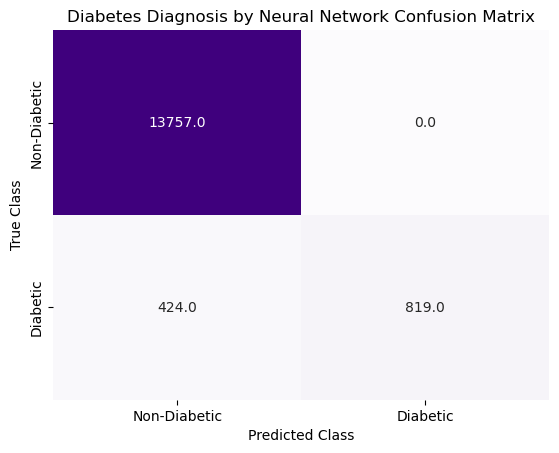

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating Confusion Matrix
cm = confusion_matrix(test_targ_tensor.numpy(), output_round)
class_names = ['Non-Diabetic', 'Diabetic']
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Visualizing the Confusion Matrix as a Heatmap
sns.heatmap(cm_df, annot=True, cbar=None, cmap='Purples', fmt='.1f')
plt.title('Diabetes Diagnosis by Neural Network Confusion Matrix')
plt.ylabel('True Class'), plt.xlabel('Predicted Class')
plt.show()

The confusion matirx here shows that the significant majority of the test data was not truly diabetic (13757 / 15000 or around 91% of the testing data). The model perfectly predicted all non-diabetics in the testing dataset. However, we can see from our recall score of around 0.66 that the model correctly predicted a diabetes diagnosis two thirds of the time among those that were actually diabetic.
<br>
<br>
A ROC Curve would also be helpful for evaluating the model.

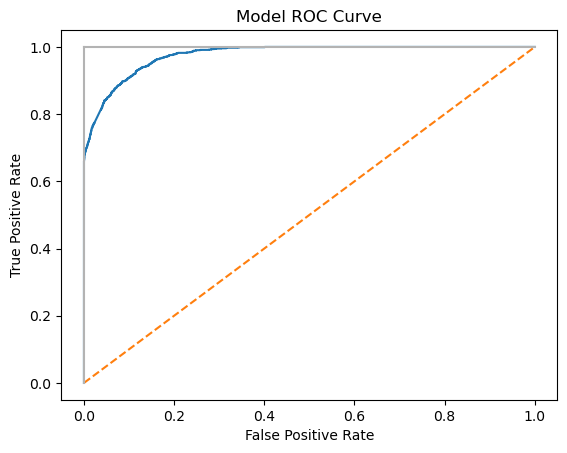

AUC Score =  0.9762127388552166


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# Making the ROC Curve
fp_rate, tp_rate, threshold = roc_curve(
    test_targ_tensor.numpy(), output_act)

# Plotting the ROC Curve
plt.title('Model ROC Curve')
plt.plot(fp_rate, tp_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c='.7'), plt.plot([1,1], c='.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print('AUC Score = ', roc_auc_score(test_targ_tensor.numpy(), output_act))

Since the output of the model is already in terms of probabilities of the diabetic class, we are able to use those in conjunction with the actual values to create a ROC curve. The curve itself looks smooth and in the upper left area of the graph, signifying a high quality model.
<br>
<br>
Lastly we can look into why a third of the actual diabetics were predicted to be not-diabetic. Violin plots can combine features of boxplots and histograms, so those will be useful for displaying the data. We will also want to look at summary statistic numbers. Doing this would be easier if we can combine the testing feature data as a dataframe and incorportate the predicted and actual diagnosis values.

In [39]:
# Bringing together the predicted and actual values as a dataframe
test_outs = pd.DataFrame({'Predicted' : output_round.reshape(15000),
                          'Output Prob' : output_act.reshape(15000),
                          'Actual' : test_targ})

In [41]:
# Merging the test feature and output dataframes
full_test_data = pd.merge(test_feats, test_outs, on=test_feats.index, how='outer').drop(columns=['key_0'])

In [43]:
# De-converting numerical field data
full_test_data.age = (full_test_data.age * raw_data.age.std()) + raw_data.age.mean()
full_test_data.bmi = (full_test_data.bmi * raw_data.bmi.std()) + raw_data.bmi.mean()
full_test_data.HbA1c_level = (full_test_data.HbA1c_level * raw_data.HbA1c_level.std()) + raw_data.HbA1c_level.mean()
full_test_data.blood_glucose_level = (full_test_data.blood_glucose_level * raw_data.blood_glucose_level.std()) + raw_data.blood_glucose_level.mean()

In [45]:
full_test_data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,Predicted,Output Prob,Actual
0,36.0,0,0,23.45,5.0,155.0,1,0,0,0,1,0,0,0,0,0.0,7.301742e-07,0
1,78.0,0,0,36.05,5.0,130.0,1,0,0,0,0,0,1,0,0,0.0,6.873063e-04,0
2,15.0,0,0,30.36,6.1,200.0,0,1,0,0,0,0,0,1,0,0.0,6.258519e-03,0
3,53.0,0,0,31.75,4.0,200.0,1,0,0,1,0,0,0,0,0,0.0,6.516791e-15,0
4,15.0,0,0,21.76,4.5,130.0,1,0,0,1,0,0,0,0,0,0.0,1.863366e-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,45.0,0,0,32.81,4.5,145.0,1,0,0,0,0,0,1,0,0,0.0,4.216201e-11,0
14996,32.0,0,0,37.71,6.1,126.0,0,1,0,0,0,1,0,0,0,0.0,6.945978e-02,0
14997,13.0,0,0,21.01,4.8,140.0,0,1,0,0,0,0,0,1,0,0.0,1.568463e-08,0
14998,25.0,0,0,27.32,5.8,145.0,0,1,0,1,0,0,0,0,0,0.0,7.047149e-03,0


Text(0.5, 0, 'Predicted Diabetes Diagnosis Value')

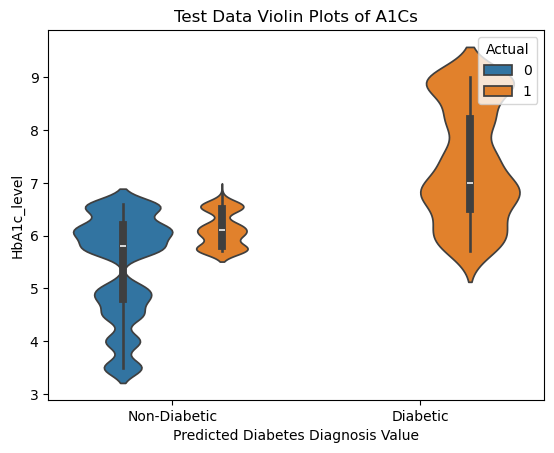

In [47]:
labels = ['Non-Diabetic', 'Diabetic']

# Violinplots for A1C Values
sns.violinplot(data=full_test_data, x='Predicted', y='HbA1c_level', hue='Actual', density_norm='count')
plt.xticks(ticks=[0,1], labels=labels)
plt.title('Test Data Violin Plots of A1Cs')
plt.xlabel('Predicted Diabetes Diagnosis Value')

Text(0.5, 0, 'Predicted Diabetes Diagnosis Value')

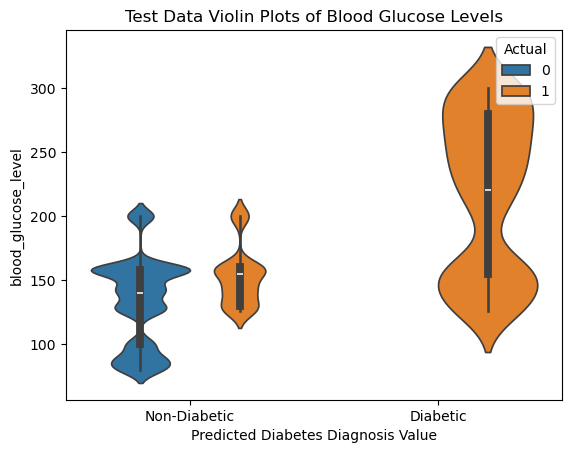

In [49]:
# Violinplots for Blood Glucose Values
sns.violinplot(data=full_test_data, x='Predicted', y='blood_glucose_level', hue='Actual', density_norm='count')
plt.xticks(ticks=[0,1], labels=labels)
plt.title('Test Data Violin Plots of Blood Glucose Levels')
plt.xlabel('Predicted Diabetes Diagnosis Value')

Text(0.5, 0, 'Predicted Diabetes Diagnosis Value')

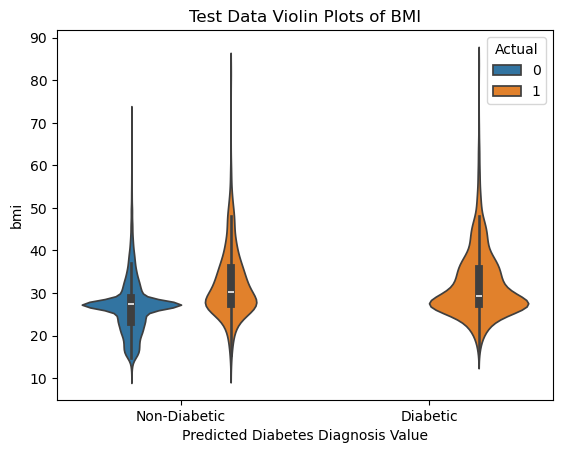

In [51]:
# Violinplots for BMI Values
sns.violinplot(data=full_test_data, x='Predicted', y='bmi', hue='Actual', density_norm='count')
plt.xticks(ticks=[0,1], labels=labels)
plt.title('Test Data Violin Plots of BMI')
plt.xlabel('Predicted Diabetes Diagnosis Value')

In [53]:
full_test_data.groupby('Predicted').agg({'HbA1c_level' : ['describe']}).round(decimals=3)

HbA1c_level                                       
             describe                                       
                count   mean    std  min  25%  50%  75%  max
Predicted                                                   
0.0           14181.0  5.425  0.969  3.5  4.8  5.8  6.2  6.8
1.0             819.0  7.381  1.099  5.7  6.5  7.0  8.2  9.0

In [55]:
full_test_data.groupby('Predicted').agg({'blood_glucose_level' : ['describe']}).round(decimals=3)

blood_glucose_level                                               \
                     describe                                                
                        count     mean     std    min    25%    50%    75%   
Predicted                                                                    
0.0                   14181.0  133.549  34.077   80.0  100.0  140.0  158.0   
1.0                     819.0  216.751  61.286  126.0  155.0  220.0  280.0   

                  
                  
             max  
Predicted         
0.0        200.0  
1.0        300.0

In [57]:
full_test_data.groupby('Predicted').agg({'bmi' : 'describe'}).round(decimals=3)

bmi                                                   
             count    mean    std    min    25%    50%     75%    max
Predicted                                                            
0.0        14181.0  26.992  6.430  10.76  23.33  27.32  29.040  81.73
1.0          819.0  31.949  7.818  16.44  27.32  29.40  35.675  83.74

In [59]:
full_test_data.groupby('Actual').agg({'HbA1c_level' : ['describe']}).round(decimals=3)

HbA1c_level                                       
          describe                                       
             count   mean    std  min  25%  50%  75%  max
Actual                                                   
0          13757.0  5.403  0.974  3.5  4.8  5.8  6.2  6.6
1           1243.0  6.947  1.093  5.7  6.1  6.6  7.5  9.0

In [61]:
full_test_data.groupby('Actual').agg({'blood_glucose_level' : ['describe']}).round(decimals=3)

blood_glucose_level                                                    
                  describe                                                    
                     count     mean     std    min    25%    50%    75%    max
Actual                                                                        
0                  13757.0  132.961  34.210   80.0  100.0  140.0  158.0  200.0
1                   1243.0  194.871  59.727  126.0  145.0  160.0  260.0  300.0

In [63]:
full_test_data.groupby('Actual').agg({'bmi' : 'describe'}).round(decimals=3)

bmi                                                   
          count    mean    std    min    25%    50%     75%    max
Actual                                                            
0       13757.0  26.835  6.316  10.76  23.21  27.32  28.790  72.03
1        1243.0  31.993  7.835  13.73  27.32  29.73  35.735  83.74

In [65]:
ROC_Curve_data = pd.DataFrame({'FP Rate' : fp_rate,
                               'TP Rate' : tp_rate,
                               'Threshold' : threshold})

In [67]:
# Writing Testing data to Excel Files for Presentation
with pd.ExcelWriter('Test Data and Metrics.xlsx') as writer: 
    full_test_data.to_excel(writer, sheet_name='Test Data', index=False,)
    ROC_Curve_data.to_excel(writer, sheet_name='ROC Curve Data', index=False)
    cm_df.to_excel(writer, sheet_name='Confusion Matrix')

In [69]:
dummied.corr()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008,0.030480,-0.030282,-0.007348,-0.276945,0.030946,0.065768,0.216481,0.065498,0.067663
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823,-0.014318,0.014423,-0.003816,-0.117210,0.017930,0.023124,0.083401,0.045953,0.000997
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727,-0.077832,0.077911,-0.002718,-0.052398,0.007604,0.040671,0.095194,-0.030843,0.007922
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357,0.023016,-0.023021,0.000119,-0.222553,0.053617,0.044343,0.111312,0.086849,0.034979
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660,-0.020015,0.020058,-0.001528,-0.045979,0.006123,0.009655,0.037306,0.010684,0.009830
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558,-0.017200,0.017189,0.000457,-0.051635,0.012447,0.006267,0.040688,0.012475,0.008613
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000,-0.037553,0.037666,-0.004090,-0.118939,0.019606,0.024080,0.097917,0.027267,0.020734
gender_Female,0.030480,-0.014318,-0.077832,0.023016,-0.020015,-0.017200,-0.037553,1.000000,-0.999629,-0.015948,-0.053810,-0.026517,-0.011019,-0.048927,0.098682,0.011419
gender_Male,-0.030282,0.014423,0.077911,-0.023021,0.020058,0.017189,0.037666,-0.999629,1.000000,-0.011285,0.053833,0.026636,0.010991,0.049048,-0.098547,-0.011985
gender_Other,-0.007348,-0.003816,-0.002718,0.000119,-0.001528,0.000457,-0.004090,-0.015948,-0.011285,1.000000,-0.000695,-0.004293,0.001062,-0.004310,-0.005181,0.020760
